In [1]:
import os
import sys
import requests
import tensorflow as tf

sys.path.append(os.pardir)
import rsmine.coarsegrainer.build_dataset as ds
import rsmine.coarsegrainer.cg_optimisers as cg_opt
import rsmine.coarsegrainer.plotter as plotter

/Users/efe/Documents/Research/RSMI-NE/rsmine/coarsegrainer/build_dataset.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# RSMI optimisation for the dimer model

## Download sample dataset

In [2]:
url = 'https://polybox.ethz.ch/index.php/s/bUp9a5qZWuLGXMb/download'
filename = 'configs_intdimer2d_square_L64_T15.000.npy'
data_dir = os.path.join(os.pardir, 'data')

if os.path.isfile(os.path.join(data_dir, filename)):
    print('Existing dataset found.')
else:
    print('No existing dataset found.')
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)
        print('Created the data directory.')
    print('Downloading data...')
    r = requests.get(url, allow_redirects=True)
    open(os.path.join(data_dir, filename), 'wb').write(r.content)
    print('Data downloaded into /coarsegrainer/data/.')

Existing dataset found.


## Enter system parameters

In [3]:
data_params = {
    'model': 'intdimer2d',
    'lattice_type': 'square',
    'L': 64,
    'T': 15.000,
    'N_samples': 28800, 
    'dimension': 2,
}

generator=ds.dataset(**data_params)

print(data_params)

Existing data found.
 Loading the data...
Loading complete.
{'model': 'intdimer2d', 'lattice_type': 'square', 'L': 64, 'T': 15.0, 'N_samples': 28800, 'dimension': 2}


## Enter optimisation parameters

In [16]:
CG_params = {'init_temperature': 0.75,
    'min_temperature': 0.1,
    'relaxation_rate': 0.0001, 
    'Nq': None,
    'conv_activation': 'tanh',# None,
    'hidden_dim': 2,
    'h_embed': True,
    'use_probs': False,
    'use_logits': True,
    'nonlinearCG': False,
    'use_STE': False,
}
ll = CG_params['ll'] = (8,8)

critic_params = {
    'layers': 3, 
    'embed_dim': 8, 
    'hidden_dim': 32, 
    'activation': 'swish',
    'use_dropout': True,
    'dropout_rate': 0.2,
}

lr = 9e-3
opt_params = {
    "batch_size": 750, 
    "iterations": 250, 
    "shuffle": 100000,
    "learning_rate": lr,
}

index = (10, 10) # index of the visible patch to be coarse-grained
buffer_size = 4
env_size = 4

V, E = generator.rsmi_data(index, ll, buffer_size=buffer_size, cap=ll[0]+2*(buffer_size+env_size))

Preparing the RSMI dataset...
RSMI dataset prepared.


## Perform the optimisation and plot results

In [17]:
estimates, _, filters, _ = cg_opt.train_RSMI_optimiser(CG_params, critic_params, opt_params, data_params,
                                                       E=E, V=V, use_GPU=True, use_notebook=True)

  0%|          | 0/19500 [00:00<?, ?it/s]

Len dat:  19500


2023-07-28 16:41:07.696088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-07-28 16:41:09.426577: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Training complete.


RSMI estimate is  0.06704431141468542
{'init_temperature': 0.75, 'min_temperature': 0.1, 'relaxation_rate': 0.0001, 'Nq': None, 'conv_activation': 'tanh', 'hidden_dim': 2, 'h_embed': True, 'use_probs': False, 'use_logits': True, 'nonlinearCG': False, 'use_STE': False, 'll': (8, 8)}
{'layers': 3, 'embed_dim': 8, 'hidden_dim': 32, 'activation': 'swish', 'use_dropout': True, 'dropout_rate': 0.2}
{'batch_size': 750, 'iterations': 500, 'shuffle': 100000, 'learning_rate': 0.009}


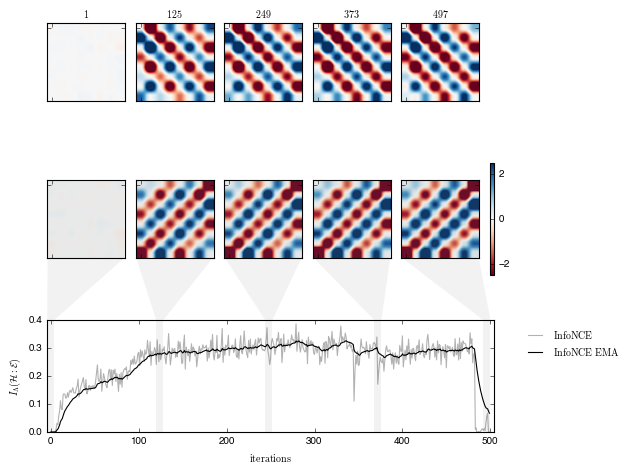

In [18]:
print('RSMI estimate is ', cg_opt.RSMI_estimate(estimates, ema_span=20))

plotter.plot_fancy_rsmimax(estimates, filters, opt_params, CG_params,
                            mi_bound=r'$\rm InfoNCE$', 
                            filter_lim=2.5, EMA_span=20, save=False, 
                            series_skip=opt_params['iterations']//4-1, 
                            interpolation='hanning', cmap='RdBu')

print(CG_params)
print(critic_params)
print(opt_params)